In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')

# TIC = 'TIC 219107776'
# TIC = 'TIC 425064757'
# TIC = 'TIC 3547397'
# TIC = 'TIC 17897279'
TIC = 'TIC 3034524'
TIC = 'TIC 219107776' #Ex Dra

cadence_magnifier = 10
cadence = 120
no_test_chunks = 10000

PREPARING THE DATA
-------------

This section downloads the desired lightcurves and performs some preliminary operations on them. The operations are:

- Removing the NaNs
- Removing the big features (like outbursts, etc.)
- Interpolating (or increasing the cadence of) the lightcurves

SearchResult containing 30 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   219107776      0.0
  1 TESS Sector 15 2019   SPOC     120   219107776      0.0
  2 TESS Sector 16 2019   SPOC     120   219107776      0.0
  3 TESS Sector 17 2019   SPOC     120   219107776      0.0
  4 TESS Sector 18 2019   SPOC     120   219107776      0.0
  5 TESS Sector 20 2019   SPOC     120   219107776      0.0
  6 TESS Sector 23 2020   SPOC     120   219107776      0.0
  7 TESS Sector 21 2020   SPOC     120   219107776      0.0
  8 TESS Sector 26 2020   SPOC     120   219107776      0.0
...            ...  ...    ...     ...         ...      ...
 20 TESS Sector 58 2022   SPOC     120   219107776      0.0
 21 TESS Sector 56 2022   SPOC     120   219107776      0.0
 22 TESS Sector 55 2022   SPOC     120   219107776      0

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

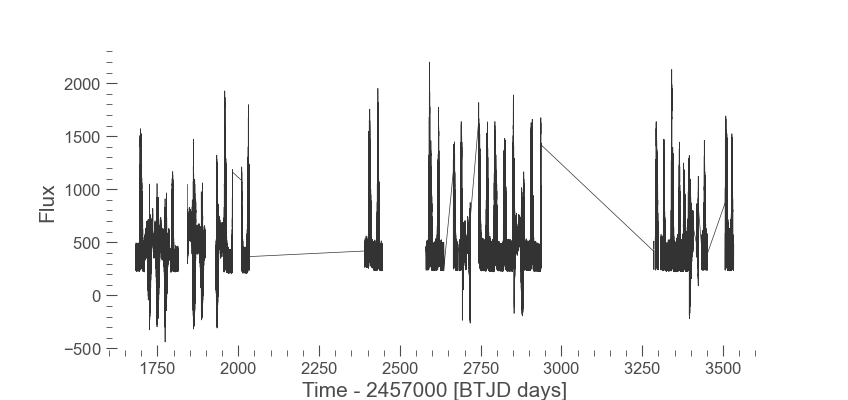

In [2]:
# Gets the lightcurves into a list[Lightcurve]
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=100, use_from=0)
lightcurve = combine_lightcurves(lcs)
lightcurve.plot()

Gaps at times: [1696.38854348]
[ 9244 18423]
Splining values between  1683.3538039950654  and  1696.3885434814729
Splining values between  1697.3441011016257  and  1710.2038436569273
Gaps at times: [1721.58580465]
[ 7252 14741]
Splining values between  1711.3649579589255  and  1721.5858046524227
Splining values between  1724.9413725859486  and  1735.501110123936
Gaps at times: [1748.68724642]
[ 7170 14586]
Splining values between  1738.6525101186708  and  1748.687246421352
Splining values between  1751.6567018246278  and  1762.0219925586134
Gaps at times: [1773.58173744]
[ 6275 12883]
Splining values between  1764.6845083315857  and  1773.5817374363542
Splining values between  1777.7303607286885  and  1787.0095319473185
Gaps at times: [1791.10954097 1800.4581543 ]
[  323  6839 14007]
Splining values between  1790.6567635368556  and  1791.1095409747213
Splining values between  1791.3692629840225  and  1800.4581543034874
Splining values between  1803.448438578751  and  1813.5789913982153

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

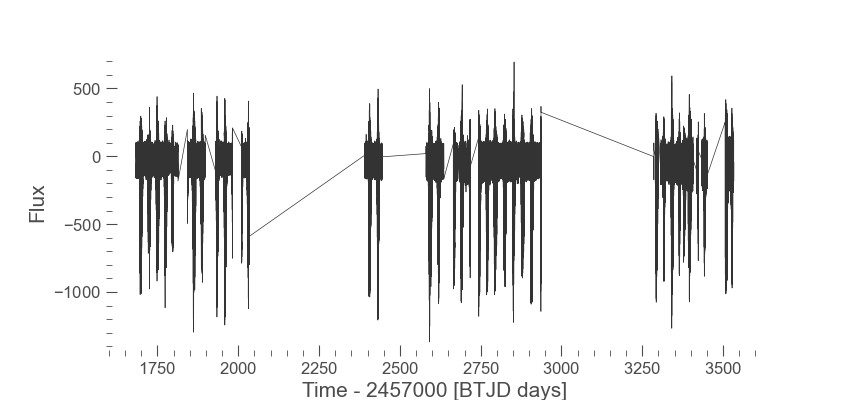

In [3]:
#Preparing the Lightcurves for analysis
new_lcs = []

for lc in lcs:  
    #Removing Nans from the Lightcurves
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])

    #new_lc = lc.remove_nans()                  #Potential alternative solution
    
    #Removing the big trends AND increasing the cadence.
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=( 3600*50 )/120, iterations=3)
    new_lc = spline_while_jumping_gaps(new_lc, cadence_magnifier= cadence_magnifier)

    #Storing away the adjusted & splined curve
    new_lcs.append(new_lc)

lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot()

#IMPORTANT Note: The straight lines between gaps seen below are not present in the data, Python adds them just for the graphs to make them visually continuous. The data is not continuous for that part.

In [ ]:
'''
Built straight lines between the gaps but tbh, I don't understand why we need straight lines?
When we talk about the periodogram, it's better to use non-interpolated data, right? 
And when we talk about gaussians, it becomes easier to eliminate incomplete(gap containing ones) if we have gaps in data. What the hell?? I guess 5 AM hits different.
'''

#Fill the gaps with straight lines (WHYYY???)

# new_lightcurve = straight_lines(lightcurve, cadence_magnifier= 1)
# axess = new_lightcurve.plot()
# lightcurve.plot(ax= axess, color= 'red')

FINDING THE PERIOD
-------------

The next section here finds the period to be used for O-C calculations as well as for folding.
A gaussian curve is fit on a Periodogram that is obtained from the desired `lightcurve`.

Please click on the desired peak to make the program process data, the peak should be the tallest peak in the entire mess of principle peak.

PS: Clicking on a point draws a gaussian which is selected for the O-C calculations. If you miss-clicked, just click on the right point afterwards and it will draw a curve in a different color, allowing you to choose another point.

Guessed peak width is 0.00027029622261631395
184982


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': '31baf5b7-1b05-4d1a-9631-0bfc62a2c60c',
              'x': array([ 4.67732361,  4.68312362,  4.68952365,  4.69052365,  4.69152365,
                           4.69372366,  4.69552367,  4.70032368,  4.70152369,  4.70272369,
                           4.70332369,  4.70392369,  4.70852371,  4.70992371,  4.71592373,
                           4.71712374,  4.71932374,  4.72012375,  4.72072375,  4.72132375,
                           4.72212375,  4.72272376,  4.72432376,  4.72512376,  4.72632377,
                           4.72692377,  4.72792377,  4.72872378,  4.72972378,  4.73172379,
                           4.73292379,  4.73352379,  4.7363238 ,  4.74512383,  4.74792384,
                           4.74872384,  4.74992385,  4.75072385,  4.75132385,  4.75232385,
                           4.75352386,  4.75672

[8.99810691e+01 4.76333303e+00 2.31058490e-04]


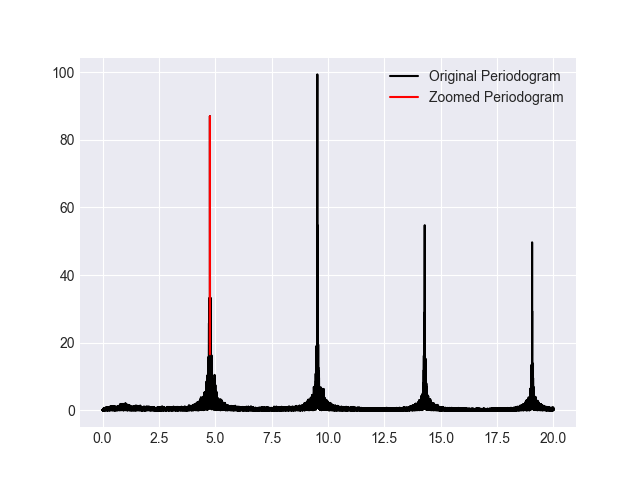

In [4]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 20)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(f'Guessed peak width is {peak_width}')
max_power = periodogram.max_power.value
optimized_parameters_global = []

frequencies = periodogram.frequency.value
print(len(frequencies))
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 100000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})
periodogram_df = pd.DataFrame({'frequencies': f, 'power': p})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        point_freq = peaks_df['frequencies'][i]

        zoomed_df = periodogram_df[periodogram_df['frequencies'].between(point_freq - (1.5*peak_width), point_freq + (1.5*peak_width))]

        fig, ax = plt.subplots()
        ax.plot(f, p, label = "Original Periodogram", color = 'black')
        ax.plot(zoomed_df['frequencies'], zoomed_df['power'], label = "Zoomed Periodogram", color = 'red')
        ax.legend()

        optimized_parameters, covariance = optimize.curve_fit(gaussian, zoomed_df['frequencies'], zoomed_df['power'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)

        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])
    
scatter.on_click(update_point)
fi


In [5]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

Fitted Frequency: 4.763333028482103
Fitted Period: 0.20993703233020908


DIVIDING INTO CHUNKS
----------

Next part of the code divides the lightcurve into chunks and also removes any chunks that have less that 80% of the average number of values.

In [6]:
#Dividing the lightcurve into chunks, the size of a chunk is the fitted period.
lightcurve_df = pd.DataFrame({'time': lightcurve.time.btjd, 'flux': np.array(lightcurve.flux, dtype='f')})
curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period

chunks = []
chunk_centres = []

for i in tqdm(range(1, no_test_chunks+1)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        all_chunk_count = i
        break
    else:
        #Only the timestamps between initial_time and end_time are stored inside a chunk.
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] < curr_end_time)]
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period


        #Use only the chunks that are within expected lengths
        expected_length = fitted_period * 86400 / (cadence / cadence_magnifier)
        if (len(chunk) < 1.2 * expected_length) and (len(chunk) > 0.8 * expected_length):
            chunks.append(chunk)
            chunk_centres.append(curr_initial_time - (fitted_period/2))

if not all_chunk_count:
    all_chunk_count = no_test_chunks

chunk_lengths = [len(chunk) for chunk in chunks]
avg_chunk_length = pd.Series(chunk_lengths).mean()

print(f'Number of chunks is {len(chunks)}')
print(f'Mean of chunk lengths is {avg_chunk_length}')


 88%|████████▊ | 8811/10000 [00:56<00:07, 157.07it/s]

Number of chunks is 3136
Mean of chunk lengths is 1509.6667729591836


In [ ]:
'''Run to save the chunks as images.'''

for i in tqdm(range(len(chunks))):
    plt.figure(figsize=(10, 6))
    plt.title(f'Chunk {i}')
    plt.plot(chunks[i]['time'], chunks[i]['flux'], lw=0.5)
    plt.axvline(chunk_centres[i], color='red', lw=0.5)
    plt.savefig(f'AnotherChunks/{i}.png')
    plt.close()

INFORMING THE PROGRAM ABOUT THE POSITION OF THE GAUSSIAN
---------
Click on two points that, according to you, give a good '[Full Width at Half Maximum](https://en.wikipedia.org/wiki/Full_width_at_half_maximum).' The program will use this as an initial guess, majorly for horizontal position. Leave the rest to the Gods and destiny.

Also, the default chunk used as sample is the first one. If you want a different `nth` chunk, enter into `chunk_num`.

PS: You can chose more than once, it will just use your final choice.

In [8]:
chunk_num = 20        #Which chunk to use for testing?

sample_chunk = chunks[chunk_num]
chunk_centre = chunk_centres[chunk_num]
sample_chunk_markers = sample_chunk.iloc[::10, :]

gaussian_peak_width = 0
gaussian_position_relative_to_centre = 0

chunk_fi = go.FigureWidget([
    go.Scatter(x=sample_chunk_markers['time'], y=sample_chunk_markers['flux'], mode='markers', name='Sampled Points', marker= {'symbol': 'bowtie', 'size': 10, 'color':'red'}),
    go.Scatter(x=sample_chunk['time'], y=sample_chunk['flux'], mode='lines', name='Chunk', line=dict(color='blue')),
], layout = go.Layout(title='Sample Chunk', xaxis_title='Time [BTJD]', yaxis_title='Flux', autosize=False, width = 1500, height=700))

chunk_scatter = chunk_fi.data[0]
chunk_fi.layout.hovermode = 'closest'


def first_input(trace, points, selector):
    '''
    This function is used to store the first point clicked in the chunk.
    '''
    global point1_time
    global point1_flux
    point1_time = points.xs[0]
    point1_flux = points.ys[0]

def second_input(trace, points, selector):
    '''
    Takes in the second point clicked and fits a gaussian to the chunk. The main function is to get the peak width and position relative to the centre.
    '''
    global point2_time
    global point2_flux
    global gaussian_peak_width
    global gaussian_position_relative_to_centre
    point2_time = points.xs[0]
    point2_flux = points.ys[0]

    gaussian_peak_width = abs(point2_time - point1_time)
    gaussian_position_relative_to_centre = (point2_time + point1_time)/2 - chunk_centre

    height = 0 - sample_chunk['flux'].min()
    cen = chunk_centre + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, sample_chunk['time'], sample_chunk['flux'], p0=initial_guess)
    amp, cen, wid = optimized_parameters

    fitted_gaussian = inverse_gaussian(sample_chunk['time'], amp, cen, wid)
    initial_gaussian = inverse_gaussian(sample_chunk['time'], *initial_guess)

    chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
    chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))

current_func = first_input

def toggle_clicker(trace, points, state):
    global current_func
    current_func(trace, points, state)

    # Switch to the other function
    if current_func == first_input:
        current_func = second_input
    else:
        current_func = first_input

chunk_scatter.on_click(toggle_clicker)
chunk_fi



FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 10, 'symbol': 'bowtie'},
              'mode': 'markers',
              'name': 'Sampled Points',
              'type': 'scatter',
              'uid': '5fe813d5-3243-45f4-b8c4-02add4a03c24',
              'x': array([1687.5526043 , 1687.5539932 , 1687.55538211, 1687.55677101,
                          1687.55815992, 1687.55954882, 1687.56093773, 1687.56232663,
                          1687.56371554, 1687.56510445, 1687.56649335, 1687.56788226,
                          1687.56927116, 1687.57066007, 1687.57204897, 1687.57343788,
                          1687.57482678, 1687.57621569, 1687.5776046 , 1687.5789935 ,
                          1687.58038241, 1687.58177131, 1687.58316022, 1687.58454912,
                          1687.58593803, 1687.58732693, 1687.58871584, 1687.59010474,
                          1687.59149365, 1687.59288256, 1687.59427146, 1687.59566037,
                          1687.59704927, 1687.59843818, 

In [ ]:
'''Creates a dataframe and a csv file with the chunk data.'''

chunks_df = pd.DataFrame({
    'chunk' : chunks,
    'chunk_number' : [i for i in range(len(chunks))],
    'chunk_len' : [len(chunk) for chunk in chunks],
}).to_csv('chunks.csv', index=False)

chunks[0]

FITTING GAUSSIANS INTO CHUNKS
--------

We will take a random guess and try fitting with that guess.

In [9]:
#List to store all the times of the peak of the gaussian.
observed_centers = []

for i in tqdm(range(len(chunks))):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, chunks[i]['time'], chunks[i]['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        # plt.figure(figsize=(10, 5))
        # plt.title(f'Chunk {i} with Gaussian')
        # plt.grid(False)
        # plt.plot(chunks[i]['time'], chunks[i]['flux'])
        # plt.plot(chunks[i]['time'], fitted_gaussian, color='red')
        # plt.plot(chunks[i]['time'], initial_gaussian, color = 'black', linestyle='--', alpha=0.5)
        # plt.legend(['Chunk', 'Fitted Gaussian', 'Initial Gaussian'])
        # plt.savefig(f'ChunksWithGaussians3034524/{i}.png')
        # plt.close()

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

    

 19%|█▊        | 587/3136 [00:06<00:21, 116.16it/s]

problem at chunk 561.
Initial guess was 1858.5816280706317


 61%|██████    | 1913/3136 [00:19<00:13, 88.47it/s] 

problem at chunk 1894.
Initial guess was 2792.8014219404604


100%|██████████| 3136/3136 [00:30<00:00, 102.42it/s]


In [10]:
'''Maybe another way of fitting the gaussians?'''
observed_centers = []

for i in tqdm(range(len(chunks))):
# for i in tqdm(range(100)):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    relevant_chunk = chunks[i][ chunks[i]['time'].between(cen - (2.5*width), cen + (3*width)) ]

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, relevant_chunk['time'], relevant_chunk['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        # plt.figure(figsize=(10, 5))
        # plt.title(f'Chunk {i} with Gaussian (Focused)')
        # plt.grid(False)
        # plt.plot(chunks[i]['time'], chunks[i]['flux'])
        # plt.plot(relevant_chunk['time'], relevant_chunk['flux'], color='green')
        # plt.plot(chunks[i]['time'], fitted_gaussian, color='red')
        # plt.plot(chunks[i]['time'], initial_gaussian, color = 'black', linestyle='--', alpha=0.5)
        # plt.legend(['Chunk', 'Fitted Gaussian', 'Initial Gaussian'])
        # plt.savefig(f"ChunksWithGaussians3034524/{i} 'focused'.png")
        # plt.close()

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

100%|██████████| 3136/3136 [00:25<00:00, 124.29it/s]


The O-C, FINALLY!
------------

Just let it run, don't sweat.

In [13]:
lightcurve_test = lightcurve_df[: int(avg_chunk_length * no_test_chunks)]

O_C_df = pd.DataFrame(
    {
    'E' : [x for x in range(int(-0.6 * all_chunk_count ), int(0.6 * all_chunk_count))]
    }
)

#Finding the T_0 for Event number 0
centre = (lightcurve_test['time'].min() + lightcurve_test['time'].max())/2
T_0_index = np.searchsorted(observed_centers, centre, side='left') - 1
print(f'T_0 index is {T_0_index}')

O_C_df['C'] = observed_centers[T_0_index] + O_C_df['E'] * fitted_period

# Insert observed_centers[i] at E = int((observed_centers[i] - observed_centers[T_0_index])/fitted_period), fill the rest with NaN
O_C_df['O'] = np.nan
for i in range(len(observed_centers)):
    E_value = int(round((observed_centers[i] - observed_centers[T_0_index]) / fitted_period))
    if E_value in O_C_df['E'].values:
        O_C_df.loc[O_C_df['E'] == E_value, 'O'] = observed_centers[i]

O_C_df['O-C'] = (O_C_df['O'] - O_C_df['C']) * 86400
# O_C_df = O_C_df.dropna(inplace=False)

def parabola(x, a, b, c):
    return a*(x**2) + b*x + c

another_O_C = O_C_df.dropna(inplace=False)



# initial_guess = [(1/30000), -(1/15), -66]
# optimized_parameters, covariance = optimize.curve_fit(parabola, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

# fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
# initial_parabola = parabola(O_C_df['E'], *initial_guess)


# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(O_C_df['E'], O_C_df['O-C'], lw=0.3, marker='o', markersize=1, label = TIC)
# ax.plot(O_C_df['E'], fitted_parabola, lw=1, label = 'Fitted Parabola')
# ax.plot(O_C_df['E'], initial_parabola, lw=1, label = 'Initial Parabola', linestyle='--', alpha=0.5)
# ax.legend()
# ax.set_title(f'O-C for {TIC}')
# ax.set_xlabel('E')
# ax.set_ylabel('O-C [s]')

# O_C_df.to_csv('O_C_df.csv', index=False)

T_0 index is 1416


In [14]:
O_C_fi = go.FigureWidget([
    go.Scatter(x=O_C_df['E'], y=O_C_df['O-C'], mode='markers', name='O-C values', marker= {'symbol': 'x', 'size': 2, 'color':'red'}),
    go.Scatter(x=O_C_df['E'], y=O_C_df['O-C'], mode='lines', name='O-C again', line=dict(color='blue'), opacity=0.2)
], layout = go.Layout(title=f'O-C for {TIC}', xaxis_title='Event Number', yaxis_title='O-C (s)', autosize=False, width = 1500, height=700))

optimized_parameters_O_C_global = []

O_C_scatter = O_C_fi.data[0]
O_C_fi.layout.hovermode = 'closest'

def O_C_curfit_drawer(trace, points, state):
    c = points.ys[0]
    E_val = points.xs[0]
    a = abs(c) / (E_val**2)
    b = (another_O_C['O-C'].iloc[-1] - another_O_C['O-C'].iloc[0]) / (another_O_C['E'].iloc[-1] - another_O_C['E'].iloc[0])

    initial_guess = [a, b, c]
    optimized_parameters, covariance = optimize.curve_fit(parabola, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

    fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
    initial_parabola = parabola(O_C_df['E'], *initial_guess)

    # O_C_fi.add_trace(go.Scatter(x=O_C_df['E'], y=initial_parabola, mode='lines', name='Initial Parabola', line=dict(color=next(color_change()))))
    O_C_fi.add_trace(go.Scatter(x=O_C_df['E'], y=fitted_parabola, mode='lines', name='Fitted Parabola', line=dict(color=next(color_change()))))

    optimized_parameters_O_C_global.append(optimized_parameters)

O_C_scatter.on_click(O_C_curfit_drawer)
O_C_fi


FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'O-C values',
              'type': 'scatter',
              'uid': '9db0729d-c73a-4b5e-98cf-a1ec8b586fb3',
              'x': array([-5287, -5286, -5285, ...,  5284,  5285,  5286]),
              'y': array([nan, nan, nan, ..., nan, nan, nan])},
             {'line': {'color': 'blue'},
              'mode': 'lines',
              'name': 'O-C again',
              'opacity': 0.2,
              'type': 'scatter',
              'uid': 'd3c8bb1f-65a7-4712-bade-de3e4a7cf6bc',
              'x': array([-5287, -5286, -5285, ...,  5284,  5285,  5286]),
              'y': array([nan, nan, nan, ..., nan, nan, nan])}],
    'layout': {'autosize': False,
               'height': 700,
               'hovermode': 'closest',
               'template': '...',
               'title': {'text': 'O-C for TIC 219107776'},
               'width': 1500,
               'xa

In [19]:
print(optimized_parameters_O_C_global[-1])
a = optimized_parameters_O_C_global[-1][0]
print(f'fitted_period is {fitted_period}')
p_dot = (2 * a * 1/(fitted_period * 86400))
print(f'P_dot is {p_dot}')

[9.01488510e-07 2.21126831e-02 3.99569043e+01]
fitted_period is 0.20993703233020908
P_dot is 9.940023139536396e-11
